In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [ ]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

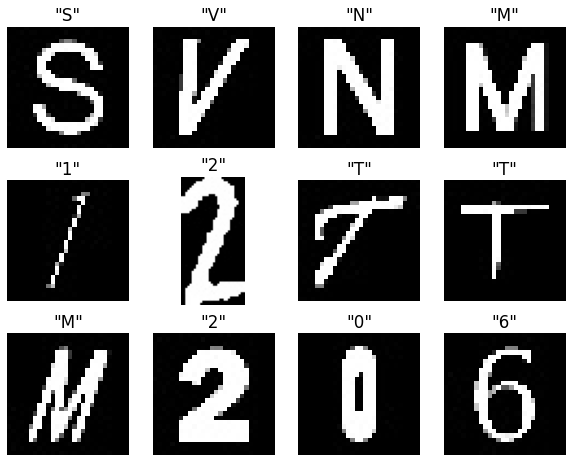

In [ ]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)

In [ ]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

[INFO] Find 37623 images with 36 classes


In [ ]:
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [ ]:
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

In [ ]:
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [ ]:

# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint(filepath="License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit_generator(image_gen.flow(trainX, trainY, batch_size=64), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 1.3502 - accuracy: 0.6237
Epoch 00001: saving model to License_character_recognition.h5
12/12 [==============================] - 2s 180ms/step - loss: 1.3502 - accuracy: 0.6237 - val_loss: 3.4287 - val_accuracy: 0.3478
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 1.2676 - accuracy: 0.6575
Epoch 00002: saving model to License_character_recognition.h5
12/12 [==============================] - 2s 184ms/step - loss: 1.2676 - accuracy: 0.6575 - val_loss: 2.9684 - val_accuracy: 0.3478
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.9559 - accuracy: 0.7244
Epoch 00003: saving model to License_character_recognition.h5
12/12 [==============================] - 2s 145ms/step - loss: 0.9559 - accuracy: 0.7244 - val_loss: 2.8284 - val_accuracy: 0.3913
Epoch 4/30
12/12 [==============================] - ETA: 0s - loss: 0.8010 - accuracy: 0.7769
Epoch 00004: saving model to License_characte

In [ ]:
model_json = model.to_json()
with open("MobileNets_character_recognition.json", "w") as json_file:
  json_file.write(model_json)